# TASK 4 - Explainable AI _ sanand3

In [45]:
import sys
print(sys.version)

import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


In [37]:
import pandas as pd
import os
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Activation, Reshape, UpSampling2D, Dense, MaxPool2D,Dropout
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers.merge import concatenate
from keras.layers import Flatten
import pydot
import warnings
warnings.filterwarnings('ignore')


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow  as tf
import keras.backend as K
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

In [9]:
dataset_seen= pd.read_csv('seen-dataset/dataset_seen_training_siamese.csv', index_col=False)
val_dataset_seen= pd.read_csv('seen-dataset/dataset_seen_validation_siamese.csv', index_col=False)

train_data_dir_seen = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_data_dir_seen)
validation_data_dir_seen= 'seen-dataset/ValidationSet/'
val_images= os.listdir(validation_data_dir_seen)

dataset_unseen= pd.read_csv('unseen-dataset/dataset_unseen_training_siamese.csv', index_col=False)
val_dataset_unseen= pd.read_csv('unseen-dataset/dataset_seen_validation_siamese.csv', index_col=False)

train_data_dir_unseen = './unseen-dataset/TrainingSet/'
validation_data_dir_unseen= './unseen-dataset/ValidationSet/'

dataset_shuffled= pd.read_csv('shuffled-dataset/dataset_seen_training_siamese.csv', index_col=False)
val_dataset_shuffled= pd.read_csv('shuffled-dataset/dataset_seen_validation_siamese.csv', index_col=False)

train_data_dir_shuffled = './shuffled-dataset/TrainingSet/'
validation_data_dir_shuffled= './shuffled-dataset/ValidationSet/'

In [13]:
dataset= pd.read_csv("15features.csv")

In [16]:
dataset_columns=dataset.columns

In [38]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [17]:
f = []
for col in dataset_columns[1:]:
    f.append(dataset[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [18]:
input_layer = Input((64,64,1))
model = BatchNormalization()(input_layer)

model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.25)(model)

model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.25)(model)

model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.25)(model)
# model = Flatten()(model)

dense_layer = Dense(512, activation='relu')(model)
dense_layer = Dropout(0.5)(dense_layer)
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Flatten()(Dense(64 , activation='relu', name = 'dense_layer_'+str(i))(dense_layer))))

human_features = Model(inputs=[input_layer], outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 64, 64, 1)    4           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 32)   32800       batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 64, 64, 64)   2097216     conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_poolin

'' was not found in history, as a file, url, nor in the user namespace.


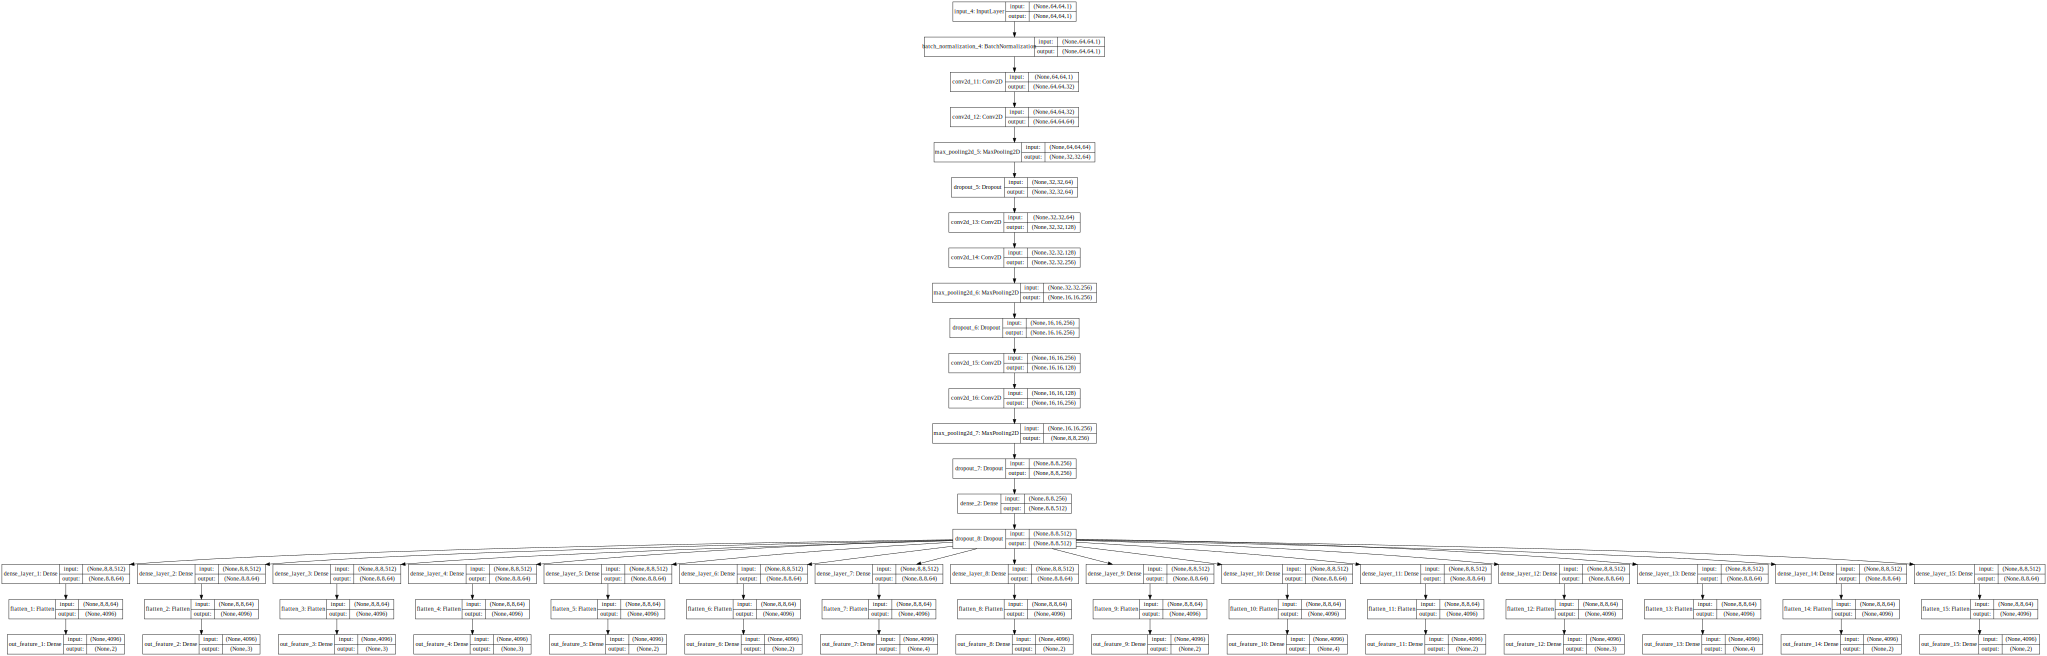

In [79]:
%save -a "1.png"
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [74]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(dataset[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

#encoder = Model(autoencoder.inputs, autoencoder.get_layer('latent').output)


[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [46]:
def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:

        
        writer_index = np.random.randint(0,len(list_of_writers))
        

        imagename = list_of_writers[writer_index]

        features = dataset[dataset['imagename']==imagename].values
        if len(features)==0:
            continue
        features = features[0][1:]-1



        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)

        counter+=1

        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):

                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]

In [47]:
batch_size = 64

tg = datagen(batch_size,image_path=train_data_dir_seen,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=validation_data_dir_seen,vshift=(-10,10), list_of_writers=val_images)

In [51]:
inputs,o = next(tg)

In [48]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0

In [61]:
from keras.optimizers import Adadelta, SGD, Adam
EPOCHS = 50000
INIT_LR = 5
opt = Adadelta(lr=INIT_LR, decay=1e-04)


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 64, 64, 1)    4           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 64, 64, 32)   32800       batch_normalization_4[0][0]      
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 64, 64, 64)   2097216     conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_poolin

In [62]:
hist = human_features.fit_generator(tg
                                    , epochs=10
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1)

Epoch 1/10
1/1 [==============================] - 117s 117s/step - loss: 13.8836 - out_feature_1_loss: 0.6889 - out_feature_2_loss: 1.0829 - out_feature_3_loss: 1.0673 - out_feature_4_loss: 1.1049 - out_feature_5_loss: 0.6405 - out_feature_6_loss: 0.6745 - out_feature_7_loss: 1.3680 - out_feature_8_loss: 0.6649 - out_feature_9_loss: 0.6220 - out_feature_10_loss: 1.3858 - out_feature_11_loss: 0.6765 - out_feature_12_loss: 1.0869 - out_feature_13_loss: 1.4236 - out_feature_14_loss: 0.6949 - out_feature_15_loss: 0.7020 - out_feature_1_acc: 0.5156 - out_feature_2_acc: 0.5156 - out_feature_3_acc: 0.5156 - out_feature_4_acc: 0.2969 - out_feature_5_acc: 0.9062 - out_feature_6_acc: 0.6719 - out_feature_7_acc: 0.4219 - out_feature_8_acc: 0.7500 - out_feature_9_acc: 0.9219 - out_feature_10_acc: 0.2188 - out_feature_11_acc: 0.7031 - out_feature_12_acc: 0.4531 - out_feature_13_acc: 0.1562 - out_feature_14_acc: 0.5469 - out_feature_15_acc: 0.4375 - val_loss: 86.1311 - val_out_feature_1_loss: 9.0664

Epoch 6/10
1/1 [==============================] - 108s 108s/step - loss: 88.9014 - out_feature_1_loss: 9.3183 - out_feature_2_loss: 7.3035 - out_feature_3_loss: 8.3109 - out_feature_4_loss: 7.8072 - out_feature_5_loss: 1.1921e-07 - out_feature_6_loss: 6.5480 - out_feature_7_loss: 6.2961 - out_feature_8_loss: 2.0148 - out_feature_9_loss: 1.0074 - out_feature_10_loss: 7.0517 - out_feature_11_loss: 3.2740 - out_feature_12_loss: 8.0590 - out_feature_13_loss: 8.8146 - out_feature_14_loss: 6.5480 - out_feature_15_loss: 6.5480 - out_feature_1_acc: 0.4219 - out_feature_2_acc: 0.5469 - out_feature_3_acc: 0.4844 - out_feature_4_acc: 0.5156 - out_feature_5_acc: 1.0000 - out_feature_6_acc: 0.5938 - out_feature_7_acc: 0.6094 - out_feature_8_acc: 0.8750 - out_feature_9_acc: 0.9375 - out_feature_10_acc: 0.5625 - out_feature_11_acc: 0.7969 - out_feature_12_acc: 0.5000 - out_feature_13_acc: 0.4531 - out_feature_14_acc: 0.5938 - out_feature_15_acc: 0.5938 - val_loss: 88.1458 - val_out_feature_1_loss: 9.

82.10154724121094


,val_loss,val_out_feature_1_loss,val_out_feature_2_loss,val_out_feature_3_loss,val_out_feature_4_loss,val_out_feature_5_loss,val_out_feature_6_loss,val_out_feature_7_loss,val_out_feature_8_loss,val_out_feature_9_loss,...,out_feature_6_acc,out_feature_7_acc,out_feature_8_acc,out_feature_9_acc,out_feature_10_acc,out_feature_11_acc,out_feature_12_acc,out_feature_13_acc,out_feature_14_acc,out_feature_15_acc


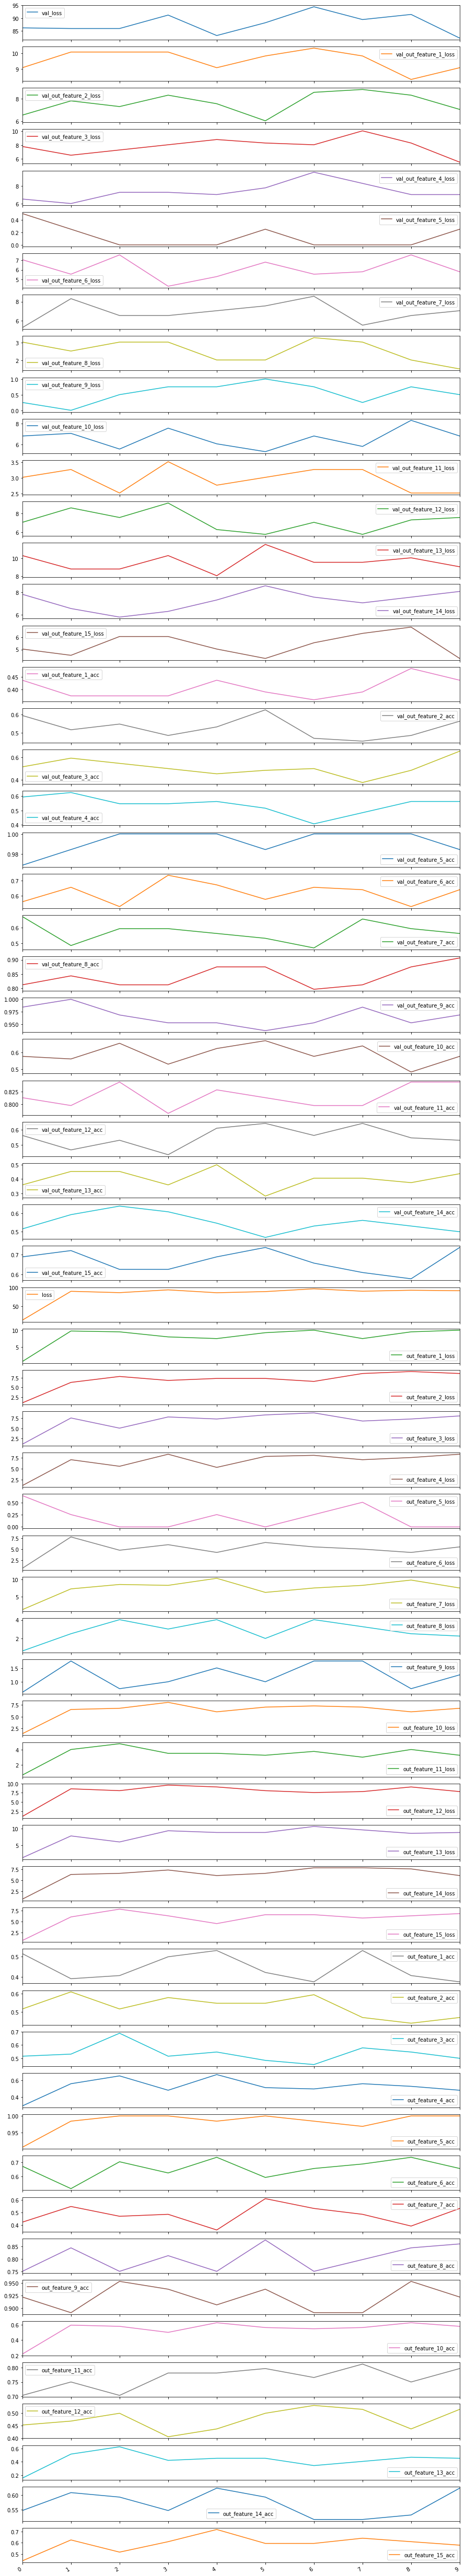

In [63]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<10.65]

In [67]:

for i in range(1,16):
    print('acc:',df_hist['val_out_feature_{0}_acc'.format(i)].max(),', loss:',df_hist['val_out_feature_{0}_loss'.format(i)].min())
print('Total Accuracy:',np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
       df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
       df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
       df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))


acc: 0.484375 , loss: 8.310893058776855
acc: 0.625 , loss: 6.044285774230957
acc: 0.65625 , loss: 5.540595054626465
acc: 0.625 , loss: 6.044285774230957
acc: 1.0 , loss: 1.1920928955078125e-07
acc: 0.734375 , loss: 4.281369209289551
acc: 0.671875 , loss: 5.288750171661377
acc: 0.90625 , loss: 1.5110714435577393
acc: 1.0 , loss: 1.1920928955078125e-07
acc: 0.671875 , loss: 5.288749694824219
acc: 0.84375 , loss: 2.5184524059295654
acc: 0.640625 , loss: 5.792440414428711
acc: 0.5 , loss: 8.05904769897461
acc: 0.640625 , loss: 5.792440414428711
acc: 0.734375 , loss: 4.281369209289551
Total Accuracy: 0.712890625


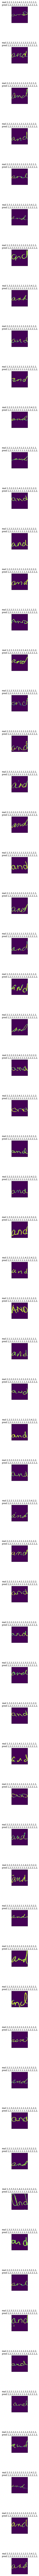

In [66]:
vx,vo=next(vg)

fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
    
    real=''
    for f in range(15):
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))

    pred=''
    for prob in f_probs:
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)


In [71]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook
